# Generating Images via Generative Models

In [2]:
# This project aims to generate images via generative models including 
# Variational Auto-encoder (VAE) [Section 2] and 
# The dataset is MNIST [Section 1].
# Evaluation by inception score and MS-SSIM as well as discussion on results is provided in [Section 3].
# Submitted for MATH63800 Final Project
# Submitted by Qing Du, Chuming DAI, Jiahao HE and Aoyu WU

## 1. Data

In [180]:
## MNIST dataset includes 60,000 training images and 10,000 test images of size 28*28 pixel with single color channel.
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [181]:
## Image Size
IMAGE_DIM = (28, 28)
IMAGE_SIZE = np.prod(IMAGE_DIM)

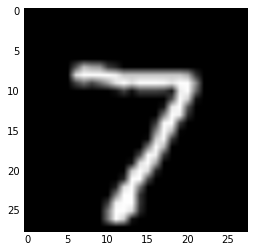

In [182]:
## Show a sample image
def show_image(arr):
    two_d = (np.reshape(arr, IMAGE_DIM) * 255).astype(np.uint8)
    plt.imshow(two_d, cmap='gray')
    return plt


show_image(mnist.test.images[0]).show()

## 2. Variational Auto-encoder (VAE)

### 2.1 Load Dataset

In [183]:
tf.reset_default_graph()

# specify variable
X = tf.placeholder(dtype=tf.float32, shape=[None, IMAGE_DIM[0], IMAGE_DIM[1]], name='X')
Y = tf.placeholder(dtype=tf.float32, shape=[None, IMAGE_DIM[0], IMAGE_DIM[1]], name='Y')
drop_out = tf.placeholder(dtype=tf.float32, shape=(), name='drop_out')
Y_flat = tf.reshape(Y, shape=[-1, 28 * 28])

# network parameters
batch_size = 64
color_channel = 1
n_latent = 8

reshaped_dim = [-1, 7, 7, color_channel]
inputs_decoder = 49 * color_channel / 2

def lrelu(x, alpha=0.3):
    return tf.maximum(x, tf.multiply(x, alpha))

### 2.2 Encoder

In [184]:
def encoder(X_in, keep_prob):
    activation = lrelu
    with tf.variable_scope("encoder", reuse=None):
        X = tf.reshape(X_in, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        mn = tf.layers.dense(x, units=n_latent)
        sd       = 0.5 * tf.layers.dense(x, units=n_latent)            
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent])) 
        z  = mn + tf.multiply(epsilon, tf.exp(sd))
        
        return z, mn, sd

### 2.3 Decoder

In [185]:
def decoder(sampled_z, keep_prob):
    with tf.variable_scope("decoder", reuse=None):
        x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=lrelu)
        x = tf.layers.dense(x, units=inputs_decoder * 2 + 1, activation=lrelu)
        x = tf.reshape(x, reshaped_dim)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=28*28, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[-1, 28, 28])
        return img

### 2.4 Training

In [186]:
sampled, mn, sd = encoder(X, drop_out)
dec = decoder(sampled, drop_out)

unreshaped = tf.reshape(dec, [-1, 28*28])
img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)
loss = tf.reduce_mean(img_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

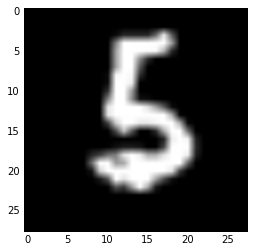

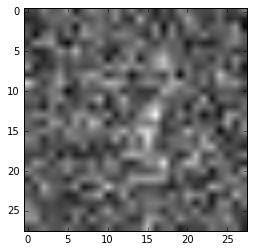

(0, 176.89397, 176.8891, 0.0048744744)


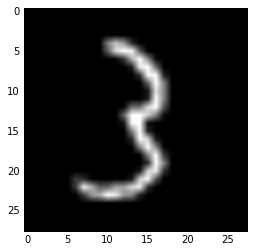

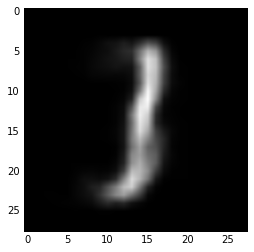

(5000, 29.025394, 19.170166, 9.8552284)


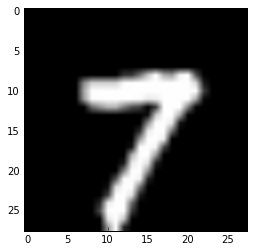

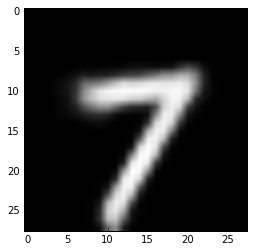

(10000, 27.840717, 17.404224, 10.436489)


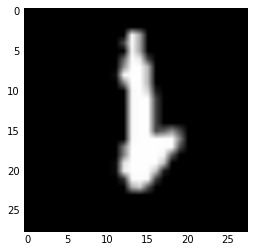

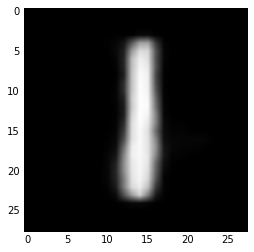

(15000, 26.619947, 16.151388, 10.468559)


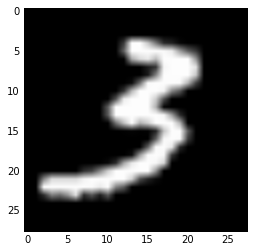

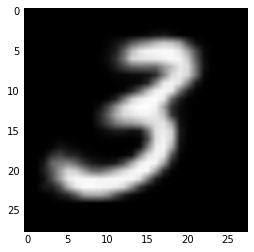

(20000, 27.532139, 16.899971, 10.63217)


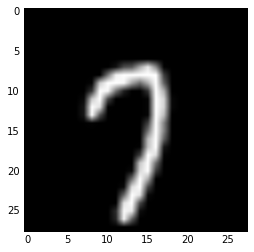

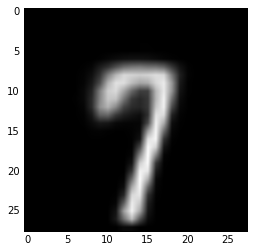

(25000, 27.65443, 16.62151, 11.032921)


In [187]:
for i in range(30000):
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]
    sess.run(optimizer, feed_dict = {X: batch, Y: batch, drop_out: 0.8})
    
    # Visualize per 5000 iter
    if not i % 5000:
        ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, img_loss, latent_loss, mn, sd], feed_dict = {X: batch, Y: batch, drop_out: 1.0})
        plt.imshow(np.reshape(batch[0], [28, 28]), cmap='gray')
        plt.show()
        plt.imshow(d[0], cmap='gray')
        plt.show()
        print(i, ls, np.mean(i_ls), np.mean(d_ls))

### 2.5 Generating

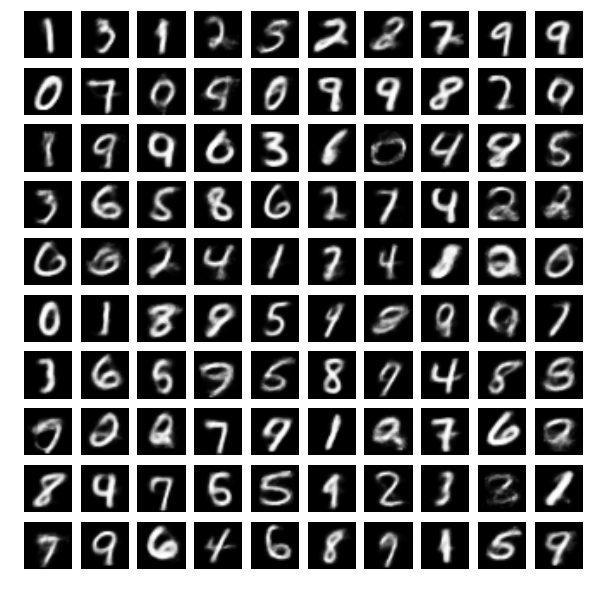

In [188]:
N_generated = 5000
randoms = [np.random.normal(0, 1, n_latent) for _ in range(N_generated)]
imgs = sess.run(dec, feed_dict = {sampled: randoms, drop_out: 1.0})
imgs = [np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))]

N_visualized = 10
fig = plt.figure(figsize=(N_visualized, N_visualized))
for i in range(0, N_visualized*N_visualized ):
    img = imgs[i]
    fig.add_subplot(N_visualized, N_visualized, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

## 3 Evaluation

### 3.1 Inception Score

In [212]:
## This section trained a model for classifying MNIST dataset
## This is used to calculate inception score
## Alternatively, one could load the trained model (see section below)
tf.reset_default_graph()
import gzip
import os

GPUID = 1
os.environ["CUDA_VISIBLE_DEVICES"] = str(GPUID)

from scipy import ndimage
from six.moves import urllib
import numpy as np
import tensorflow as tf
import tensorflow.contrib.slim as slim
print ("PACKAGES LOADED")



def CNN(inputs, _is_training=True):
    x   = tf.reshape(inputs, [-1, 28, 28, 1])
    batch_norm_params = {'is_training': _is_training, 'decay': 0.9, 'updates_collections': None}
    net = slim.conv2d(x, 32, [5, 5], padding='SAME'
                     , activation_fn       = tf.nn.relu
                     , weights_initializer = tf.truncated_normal_initializer(stddev=0.01)
                     , normalizer_fn       = slim.batch_norm
                     , normalizer_params   = batch_norm_params
                     , scope='conv1')
    net = slim.max_pool2d(net, [2, 2], scope='pool1')
    net = slim.conv2d(net, 64, [5, 5], scope='conv2')
    net = slim.max_pool2d(net, [2, 2], scope='pool2')
    net = slim.flatten(net, scope='flatten3')
    net = slim.fully_connected(net, 1024
                    , activation_fn       = tf.nn.relu
                    , weights_initializer = tf.truncated_normal_initializer(stddev=0.01)
                    , normalizer_fn       = slim.batch_norm
                    , normalizer_params   = batch_norm_params
                    , scope='fc4')
    net = slim.dropout(net, keep_prob=0.7, is_training=_is_training, scope='dropout4')  
    out = slim.fully_connected(net, 10, activation_fn=None, normalizer_fn=None, scope='fco')
    return out


# DATA URL
SOURCE_URL      = 'http://yann.lecun.com/exdb/mnist/'
DATA_DIRECTORY  = "data"
# PARAMETERS FOR MNIST
IMAGE_SIZE      = 28
NUM_CHANNELS    = 1
PIXEL_DEPTH     = 255
NUM_LABELS      = 10
VALIDATION_SIZE = 5000  # Size of the validation set.

# DOWNLOAD MNIST DATA, IF NECESSARY
def maybe_download(filename):
    if not tf.gfile.Exists(DATA_DIRECTORY):
        tf.gfile.MakeDirs(DATA_DIRECTORY)
    filepath = os.path.join(DATA_DIRECTORY, filename)
    if not tf.gfile.Exists(filepath):
        filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)
        with tf.gfile.GFile(filepath) as f:
            size = f.size()
        print('Successfully downloaded', filename, size, 'bytes.')
    return filepath

# EXTRACT IMAGES
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images * NUM_CHANNELS)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data / 255 # 0 ~ 1
        # data = (data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH # -0.5~0.5
        data = data.reshape(num_images, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)
        data = np.reshape(data, [num_images, -1])
    return data # [image index, y, x, channels]

# EXTRACT LABELS
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        num_labels_data = len(labels)
        one_hot_encoding = np.zeros((num_labels_data,NUM_LABELS))
        one_hot_encoding[np.arange(num_labels_data),labels] = 1
        one_hot_encoding = np.reshape(one_hot_encoding, [-1, NUM_LABELS])
    return one_hot_encoding

# AUGMENT TRAINING DATA
def expend_training_data(images, labels):
    expanded_images = []
    expanded_labels = []
    j = 0 # counter
    for x, y in zip(images, labels):
        j = j+1
        # APPEND ORIGINAL DATA
        expanded_images.append(x)
        expanded_labels.append(y)
        # ASSUME MEDIAN COLOR TO BE BACKGROUND COLOR
        bg_value = np.median(x) # this is regarded as background's value        
        image = np.reshape(x, (-1, 28))

        for i in range(4):
            # ROTATE IMAGE
            angle = np.random.randint(-15,15,1)
            new_img = ndimage.rotate(image,angle,reshape=False, cval=bg_value)
            # SHIFT IAMGE
            shift = np.random.randint(-2, 2, 2)
            new_img_ = ndimage.shift(new_img,shift, cval=bg_value)
            # ADD TO THE LIST
            expanded_images.append(np.reshape(new_img_, 784))
            expanded_labels.append(y)
    expanded_train_total_data = np.concatenate((expanded_images, expanded_labels), axis=1)
    np.random.shuffle(expanded_train_total_data)
    return expanded_train_total_data

# PREPARE MNIST DATA
def prepare_MNIST_data(use_data_augmentation=True):
    # Get the data.
    train_data_filename = maybe_download('train-images-idx3-ubyte.gz')
    train_labels_filename = maybe_download('train-labels-idx1-ubyte.gz')
    test_data_filename = maybe_download('t10k-images-idx3-ubyte.gz')
    test_labels_filename = maybe_download('t10k-labels-idx1-ubyte.gz')
    train_data = extract_data(train_data_filename, 60000)
    train_labels = extract_labels(train_labels_filename, 60000)
    test_data = extract_data(test_data_filename, 10000)
    test_labels = extract_labels(test_labels_filename, 10000)
    validation_data = train_data[:VALIDATION_SIZE, :]
    validation_labels = train_labels[:VALIDATION_SIZE,:]
    train_data = train_data[VALIDATION_SIZE:, :]
    train_labels = train_labels[VALIDATION_SIZE:,:]
    if use_data_augmentation:
        train_total_data = expend_training_data(train_data, train_labels)
    else:
        train_total_data = np.concatenate((train_data, train_labels), axis=1)
    train_size = train_total_data.shape[0]
    return train_total_data, train_size, validation_data, validation_labels, test_data, test_labels



# CONFIGURATION
MODEL_DIRECTORY   = "model/model.ckpt"
LOGS_DIRECTORY    = "logs/train"
training_epochs   = 10
TRAIN_BATCH_SIZE  = 50
display_step      = 500
validation_step   = 500
TEST_BATCH_SIZE   = 5000    


# PREPARE MNIST DATA
batch_size = TRAIN_BATCH_SIZE # BATCH SIZE (50)
num_labels = NUM_LABELS       # NUMBER OF LABELS (10)
train_total_data, train_size, validation_data, validation_labels \
    , test_data, test_labels = prepare_MNIST_data(True)
# PRINT FUNCTION
def print_np(x, str):
    print (" TYPE AND SHAPE OF [%18s ] ARE %s and %14s" 
           % (str, type(x), x.shape,))
print_np(train_total_data, 'train_total_data')
print_np(validation_data, 'validation_data')
print_np(validation_labels, 'validation_labels')
print_np(test_data, 'test_data')
print_np(test_labels, 'test_labels')


# DEFINE MODEL
# PLACEHOLDERS
x  = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10]) #answer
is_training = tf.placeholder(tf.bool, name='MODE')
# CONVOLUTIONAL NEURAL NETWORK MODEL 
y = CNN(x, is_training)
# DEFINE LOSS
with tf.name_scope("LOSS"):
    loss = slim.losses.softmax_cross_entropy(y, y_)
# DEFINE ACCURACY
with tf.name_scope("ACC"):
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# DEFINE OPTIMIZER
with tf.name_scope("ADAM"):
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        1e-4,               # LEARNING_RATE
        batch * batch_size, # GLOBAL_STEP
        train_size,         # DECAY_STEP
        0.95,               # DECAY_RATE
        staircase=True)     # LR = LEARNING_RATE*DECAY_RATE^(GLOBAL_STEP/DECAY_STEP)
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss,global_step=batch)
    # 'batch' IS AUTOMATICALLY UPDATED AS WE CALL 'train_step'

# SUMMARIES
saver = tf.train.Saver()
tf.summary.scalar('learning_rate', learning_rate)
tf.summary.scalar('loss', loss)
tf.summary.scalar('acc', accuracy)
merged_summary_op = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter(LOGS_DIRECTORY, graph=tf.get_default_graph())
print ("MODEL DEFINED.")


# OPEN SESSION
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
config.gpu_options.per_process_gpu_memory_fraction = 0.2
sess_incep = tf.Session(config=config)
sess_incep.run(tf.global_variables_initializer(), feed_dict={is_training: True})

PACKAGES LOADED
 TYPE AND SHAPE OF [  train_total_data ] ARE <type 'numpy.ndarray'> and  (275000, 794)
 TYPE AND SHAPE OF [   validation_data ] ARE <type 'numpy.ndarray'> and    (5000, 784)
 TYPE AND SHAPE OF [ validation_labels ] ARE <type 'numpy.ndarray'> and     (5000, 10)
 TYPE AND SHAPE OF [         test_data ] ARE <type 'numpy.ndarray'> and   (10000, 784)
 TYPE AND SHAPE OF [       test_labels ] ARE <type 'numpy.ndarray'> and    (10000, 10)
MODEL DEFINED.


In [213]:
# MAXIMUM ACCURACY
max_acc = 0.
training_epochs = 1
# LOOP
for epoch in range(training_epochs): # training_epochs: 10
    # RANDOM SHUFFLE
    np.random.shuffle(train_total_data)
    train_data_   = train_total_data[:, :-num_labels]
    train_labels_ = train_total_data[:, -num_labels:]
    # ITERATIONS
    total_batch = int(train_size / batch_size)
    for iteration in range(total_batch):
        # GET CURRENT MINI-BATCH
        offset = (iteration * batch_size) % (train_size)
        batch_xs = train_data_[offset:(offset + batch_size), :]
        batch_ys = train_labels_[offset:(offset + batch_size), :]
        # OPTIMIZE
        _, train_accuracy, summary = sess_incep.run([train_step, accuracy, merged_summary_op]
                                    , feed_dict={x: batch_xs, y_: batch_ys, is_training: True})
        # WRITE LOG
        summary_writer.add_summary(summary, epoch*total_batch + iteration)

        # DISPLAY
        if iteration % display_step == 0:
            print("Epoch: [%3d/%3d] Batch: [%04d/%04d] Training Acc: %.5f" 
                  % (epoch + 1, training_epochs, iteration, total_batch, train_accuracy))

        # GET ACCURACY FOR THE VALIDATION DATA
        if iteration % validation_step == 0:
            validation_accuracy = sess_incep.run(accuracy,
            feed_dict={x: validation_data, y_: validation_labels, is_training: False})
            print("Epoch: [%3d/%3d] Batch: [%04d/%04d] Validation Acc: %.5f" 
                  % (epoch + 1, training_epochs, iteration, total_batch, validation_accuracy))
        # SAVE THE MODEL WITH HIGEST VALIDATION ACCURACY
        if validation_accuracy > max_acc:
            max_acc = validation_accuracy
            save_path = saver.save(sess_incep, MODEL_DIRECTORY)
            print("  MODEL UPDATED TO [%s] VALIDATION ACC IS %.5f" 
                  % (save_path, validation_accuracy))
print("OPTIMIZATION FINISHED")

Epoch: [  1/  1] Batch: [0000/5500] Training Acc: 0.10000
Epoch: [  1/  1] Batch: [0000/5500] Validation Acc: 0.12700
  MODEL UPDATED TO [model/model.ckpt] VALIDATION ACC IS 0.12700
Epoch: [  1/  1] Batch: [0500/5500] Training Acc: 0.94000
Epoch: [  1/  1] Batch: [0500/5500] Validation Acc: 0.98240
  MODEL UPDATED TO [model/model.ckpt] VALIDATION ACC IS 0.98240
Epoch: [  1/  1] Batch: [1000/5500] Training Acc: 0.98000
Epoch: [  1/  1] Batch: [1000/5500] Validation Acc: 0.98540
  MODEL UPDATED TO [model/model.ckpt] VALIDATION ACC IS 0.98540
Epoch: [  1/  1] Batch: [1500/5500] Training Acc: 0.98000
Epoch: [  1/  1] Batch: [1500/5500] Validation Acc: 0.98920
  MODEL UPDATED TO [model/model.ckpt] VALIDATION ACC IS 0.98920
Epoch: [  1/  1] Batch: [2000/5500] Training Acc: 0.94000
Epoch: [  1/  1] Batch: [2000/5500] Validation Acc: 0.98960
  MODEL UPDATED TO [model/model.ckpt] VALIDATION ACC IS 0.98960
Epoch: [  1/  1] Batch: [2500/5500] Training Acc: 0.98000
Epoch: [  1/  1] Batch: [2500/55

In [211]:
# RESTORE SAVED NETWORK (alternative to the abote training process)
ifRestore = False
if ifRestore:
    # OPEN SESSION
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    config.gpu_options.per_process_gpu_memory_fraction = 0.2
    sess_incep = tf.Session(config=config)
    sess_incep.run(tf.global_variables_initializer(), feed_dict={is_training: True})
    saver.restore(sess_incep, MODEL_DIRECTORY)

In [161]:
eval_data = np.reshape(imgs, (imgs.shape[0], -1))

batch_size = 100
test_size   = eval_data.shape[0]
total_batch = int(test_size / batch_size)
acc_buffer  = []
preds = []
for i in range(total_batch):
    offset = (i * batch_size) % (test_size)
    batch_xs = eval_data[offset:(offset + batch_size), :]
    y_final = sess_incep.run(y, feed_dict={x: batch_xs, is_training: False})
    pred_softmax = softmax(y_final)
    preds.append(pred_softmax)


preds = np.concatenate(preds, 0)
scores = []
splits = 10
for i in range(splits):
    part = preds[(i * preds.shape[0] // splits):((i + 1) * preds.shape[0] // splits), :]
    kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
    kl = np.mean(np.sum(kl, 1))
    scores.append(np.exp(kl))

icp.append((np.mean(scores) , np.std(scores)))
print("Inception score is: %.4f, %.4f" % (np.mean(scores) , np.std(scores)))

Inception score is: 6.3337, 0.1720


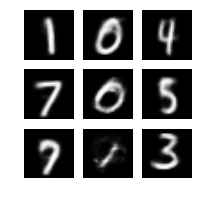

[1, 0, 4, 7, 0, 5, 7, 1, 3]


In [215]:
N_valid = 3
res_valid = []
fig = plt.figure(figsize=(N_valid, N_valid))
for i in range(0, N_valid*N_valid ):
    img = imgs[i*100]
    fig.add_subplot(N_valid, N_valid, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
    batch_xs = np.reshape(img, [1, 28*28])
    y_final = sess_incep.run(y, feed_dict={x: batch_xs, is_training: False})
    res_valid.extend(np.argmax(y_final, 1))
plt.show()
print res_valid

### 3.2 Diversity Score (MS-SSIM)

### from scipy import signal
from scipy import ndimage

def _np_fspecial_gauss(size, sigma):
    """Function to mimic the 'fspecial' gaussian MATLAB function
    """
    x_data, y_data = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]

#     x_data = np.expand_dims(x_data, axis=-1)
#     x_data = np.expand_dims(x_data, axis=-1)

#     y_data = np.expand_dims(y_data, axis=-1)
#     y_data = np.expand_dims(y_data, axis=-1)

#     x = tf.constant(x_data, dtype=tf.float32)
#     y = tf.constant(y_data, dtype=tf.float32)

    x = x_data
    y = y_data
    
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g / np.sum(g)

# def ulti_fft(n1, n2):
#     if (n1.)
    
def ssim(img1, img2, cs_map=False):
    """Return the Structural Similarity Map corresponding to input images img1 
    and img2 (images are assumed to be uint8)
    
    This function attempts to mimic precisely the functionality of ssim.m a 
    MATLAB provided by the author's of SSIM
    https://ece.uwaterloo.ca/~z70wang/research/ssim/ssim_index.m
    """
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)
    size = 7
    sigma = 1.5
    window = _np_fspecial_gauss(size, sigma)
    K1 = 0.01
    K2 = 0.03
    L = 255 #bitdepth of image
    C1 = (K1*L)**2
    C2 = (K2*L)**2
    
    mu1 = signal.fftconvolve(img1, window, mode='valid')
    mu2 = signal.fftconvolve(img2, window, mode='valid')
    mu1_sq = mu1*mu1
    mu2_sq = mu2*mu2
    mu1_mu2 = mu1*mu2
    sigma1_sq = signal.fftconvolve(img1*img1, window, mode='valid') - mu1_sq
    sigma2_sq = signal.fftconvolve(img2*img2, window, mode='valid') - mu2_sq
    sigma12 = signal.fftconvolve(img1*img2, window, mode='valid') - mu1_mu2
    
    
#     mu1 = tf.nn.conv2d(img1, window, strides=[1,1], padding='VALID')
#     mu2 = tf.nn.conv2d(img2, window, strides=[1,1],padding='VALID')
#     mu1_sq = mu1*mu1
#     mu2_sq = mu2*mu2
#     mu1_mu2 = mu1*mu2
#     sigma1_sq = tf.nn.conv2d(img1*img1, window, strides=[1,1],padding='VALID') - mu1_sq
#     sigma2_sq = tf.nn.conv2d(img2*img2, window, strides=[1,1],padding='VALID') - mu2_sq
#     sigma12 = tf.nn.conv2d(img1*img2, window, strides=[1,1],padding='VALID') - mu1_mu2
    
    if cs_map:
        result = (((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*
                    (sigma1_sq + sigma2_sq + C2)), 
                (2.0*sigma12 + C2)/(sigma1_sq + sigma2_sq + C2))
    else:
        result = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*
                    (sigma1_sq + sigma2_sq + C2))
        
#     with tf.Session() as temp_sess:
#         temp_sess.run(tf.initialize_all_variables())
#         result = result.eval()
    return result
    
    

def msssim(img1, img2):
    """This function implements Multi-Scale Structural Similarity (MSSSIM) Image 
    Quality Assessment according to Z. Wang's "Multi-scale structural similarity 
    for image quality assessment" Invited Paper, IEEE Asilomar Conference on 
    Signals, Systems and Computers, Nov. 2003 
    
    Author's MATLAB implementation:-
    http://www.cns.nyu.edu/~lcv/ssim/msssim.zip
    """
    level = 3
    weight = np.array([0.0448, 0.2856, 0.3001, 0.2363, 0.1333])
    downsample_filter = np.ones((2, 2))/4.0
    im1 = img1.astype(np.float64)
    im2 = img2.astype(np.float64)
    mssim = np.array([])
    mcs = np.array([])
    for l in range(level):
        ssim_map, cs_map = ssim(im1, im2, cs_map=True)
        mssim = np.append(mssim, ssim_map.mean())
        mcs = np.append(mcs, cs_map.mean())
        filtered_im1 = ndimage.filters.convolve(im1, downsample_filter, 
                                                mode='reflect')
        filtered_im2 = ndimage.filters.convolve(im2, downsample_filter, 
                                                mode='reflect')
        im1 = filtered_im1[::2, ::2]
        im2 = filtered_im2[::2, ::2]
    return (np.prod(mcs[0:level-1]**weight[0:level-1])*
                    (mssim[level-1]**weight[level-1]))



In [218]:
## Classify generated imgs
imgsWithCate = [(img, np.argmax(sess_incep.run(y, feed_dict={x: np.reshape(img, [1, 28*28]), is_training: False}), 1)[0]) for img in imgs]

In [368]:
from itertools import groupby
imgsByCate = list(groupby(sorted(imgsWithCate, key=lambda x: x[1]), lambda x: x[1]))

In [407]:
## Print the average MS-SSIM score among N_PAIR randomly chose pairs of images within each category
N_PAIR = 10
msssim_idx = [(i,j) for i in range(N_PAIR) for j in range(N_PAIR) if i != j]

from random import randint

def getRandomPair(m, n):
    seen = set()

    x, y = randint(m, n), randint(m, n)

    while x == y:
        x, y = randint(m, n), randint(m, n)
        
    while True:
        seen.add((x, y))
        yield (x, y)
        x, y = randint(m, n), randint(m, n)
        while (x, y) in seen:
            x, y = randint(m, n), randint(m, n)
            
for key, group in groupby(sorted(imgsWithCate, key=lambda x: x[1]), lambda x: x[1]):

    testGroups = list(group)
    p = getRandomPair(1, len(testGroups))
    msssim_idx = [next(p) for _ in range(N_PAIR)]

    scores = [msssim(testGroups[x[0]][0], testGroups[x[1]][0]) for x in msssim_idx]
    mean_score = float(sum(scores)) / max(len(scores), 1)
    print key, mean_score

0 0.99780537591
1 0.999412298204
2 0.999004630089
3 0.999148864893
4 0.999118608539
5 0.998908766239
6 0.998824292666
7 0.999122747268
8 0.999119374529
9 0.998958955887
